# 1. Citirea setului de date

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import math
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

In [2]:
modeImputer=SimpleImputer(missing_values='XX',strategy='most_frequent')
avgImputer=SimpleImputer(missing_values=-1,strategy='mean')

Inspectam coloanele

In [3]:
dataset=pd.read_csv('date_tema_1_iaut_2024.csv')
dataset.head()

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
0,Public_Transportation,2,yes,no,"3,73",21,no,2474,3,Sometimes,"1,62",no,2,no,64,0,1,Female,D1
1,Public_Transportation,3,yes,no,"2,92",21,Sometimes,2429,3,Sometimes,"1,52",yes,3,yes,56,3,0,Female,D1
2,Public_Transportation,2,yes,no,"3,85",23,Frequently,2656,3,Sometimes,"1,8",no,2,no,77,2,1,Male,D1
3,Walking,3,no,no,"3,01",27,Frequently,2260,3,Sometimes,"1,8",no,2,no,-1,2,0,Male,D2
4,Public_Transportation,2,no,no,"2,73",22,Sometimes,1895,1,Sometimes,"1,78",no,2,no,"89,8",0,0,Male,D3


In [4]:
len(dataset)

1921

# 2. Inspectarea atributelor

- ### Transportation

In [5]:
transportation=dataset["Transportation"]

Valorile unice

In [6]:
transportation.unique()

array(['Public_Transportation', 'Walking', 'Automobile', 'Motorbike',
       'Bike'], dtype=object)

Plotarea histogramei

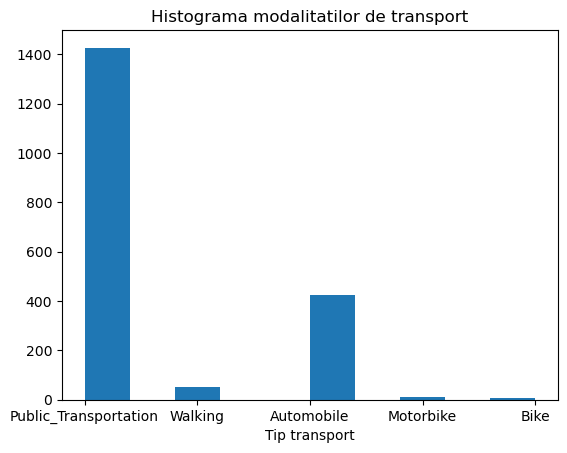

In [7]:
transportation.hist(grid=False)
plt.xlabel("Tip transport")
plt.title("Histograma modalitatilor de transport")
plt.show()

- ### Regular_fiber_diet

In [8]:
fiber_diet=dataset["Regular_fiber_diet"]

Valorile unice

In [9]:
fiber_diet.unique()

array(['2', '3', '1', '2,450218', '2,880161', '2,00876', '2,596579',
       '2,591439', '2,392665', '1,123939', '2,027574', '2,658112',
       '2,88626', '2,714447', '2,750715', '1,4925', '2,205439',
       '2,059138', '2,310423', '2,052932', '2,596364', '2,767731',
       '2,815157', '2,737762', '2,568063', '2,524428', '2,971574',
       '1,0816', '1,270448', '1,344854', '2,959658', '2,725282',
       '2,844607', '2,44004', '2,432302', '2,449267', '2,929889',
       '2,015258', '1,031149', '1,592183', '1,21498', '1,522001',
       '2,703436', '2,362918', '2,14084', '2,5596', '2,336044',
       '1,133844', '1,757466', '2,204914', '2,927218', '2,890535',
       '2,530066', '2,241606', '1,003566', '2,652779', '2,897899',
       '2,483979', '2,945967', '2,784464', '1,005578', '2,938031',
       '2,842102', '1,889199', '2,943749', '2,33998', '1,950742',
       '2,277436', '2,371338', '2,977018', '2,753752', '2,318355',
       '2,594653', '2,886157', '2,967853', '2,619835', '1,053534',
    

In [10]:
new_fiber_diet=fiber_diet.apply(lambda s: re.sub(r",","",s)).astype(int)
new_fiber_diet

0       2
1       3
2       2
3       3
4       2
       ..
1916    3
1917    3
1918    3
1919    3
1920    3
Name: Regular_fiber_diet, Length: 1921, dtype: int32

In acest dataset observam ca dincolo de valori asteptate, precum 1,2,3 care poate reprezenta continutul de fibre (scazut,mediu,mare), observam si niste anomalii: date nepermis de mari. Sa vedem totusi distributia lor.

In [11]:
new_fiber_diet.value_counts()

Regular_fiber_diet
3          597
2          551
1           28
2568063      2
2630137      2
          ... 
2119643      1
2901924      1
2451009      1
2754646      1
2680375      1
Name: count, Length: 733, dtype: int64

Sa facem un pie chart, considerand ca fiind valori ciudate, toate cele care apar de cel mult 2 ori

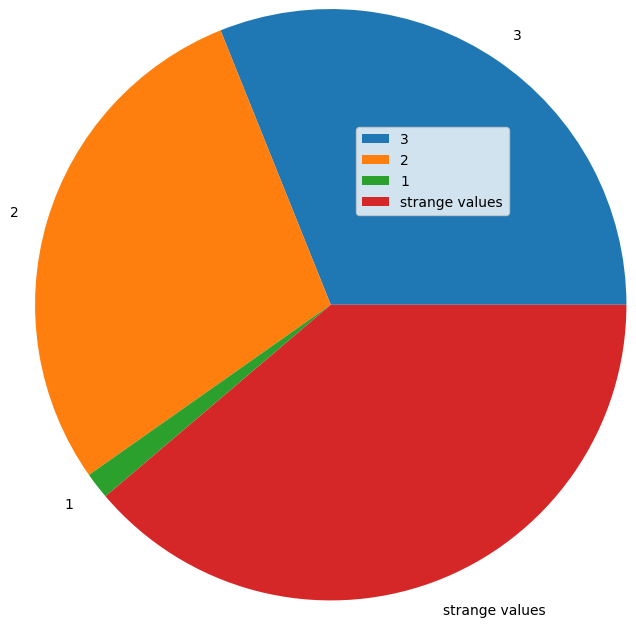

In [12]:
outlier_fiber_diet=new_fiber_diet.value_counts().iloc[3:]
total_outliers=outlier_fiber_diet.sum()
plt.pie([new_fiber_diet.value_counts().iloc[0],new_fiber_diet.value_counts().iloc[1],
         new_fiber_diet.value_counts().iloc[2],outlier_fiber_diet.to_numpy().sum()],labels=["3","2","1","strange values"],
       radius=2)
plt.legend()
plt.show()

In [13]:
outlier_indexes=new_fiber_diet[(new_fiber_diet!=1) & (new_fiber_diet!=2) & (new_fiber_diet!=3)].index.to_list()

In [14]:
def make_intervals(outlier_indexes):
    intervals=[]
    left=0
    index=0
    while index<len(outlier_indexes):
        right=outlier_indexes[index]
        while(index+1<len(outlier_indexes)):
            if(outlier_indexes[index+1]-outlier_indexes[index]==1):
                index+=1
            else:
                break
        intervals.append((left,outlier_indexes[index]))
        left=outlier_indexes[index]+1
        index+=1
    intervals.append((left,len(dataset)))
    return intervals
fiber_intervals=make_intervals(outlier_indexes)

Vazand discrepante mari in ceea ce priveste frecventa consideram inestetica o histograma. Observam ca toate valorile inexplicabil de mari pentru fiber_diet nu apar de mai mult de 2 ori, asa ca pot fi considerati outlieri

In [15]:
new_fiber_diet.value_counts(normalize=True)

Regular_fiber_diet
3          0.310776
2          0.286830
1          0.014576
2568063    0.001041
2630137    0.001041
             ...   
2119643    0.000521
2901924    0.000521
2451009    0.000521
2754646    0.000521
2680375    0.000521
Name: proportion, Length: 733, dtype: float64

Uitandu-ne din punct de vedere procentual vedem ca valorile normale (1,2,3) apar aproximativ 60% din date. Pentru a gestiona aceasta situatie, consideram urmatoarea strategie. Stiind indecsii corespunzatori valorilor problema ale coloanei, punem initial un placeholder, XX. Apoi, de la indicele 0 (prima inregistrare din tabela) pana la fiecare index unde au aparut probleme, inlocuim XX cu cea mai frecventa valoare intalnita de la inceputul datasetului si pana la indexul corespunzator fiecarei situatii problema

In [16]:
dataset.loc[outlier_indexes,"Regular_fiber_diet"]='XX'

In [17]:
for left_side,right_side in fiber_intervals:
    index=left_side
    for new_row in modeImputer.fit_transform(dataset.loc[0:right_side+1])[left_side:right_side+1]:
        dataset.loc[index]=new_row
        index+=1

In [18]:
dataset["Regular_fiber_diet"].value_counts()

Regular_fiber_diet
2    1296
3     597
1      28
Name: count, dtype: int64

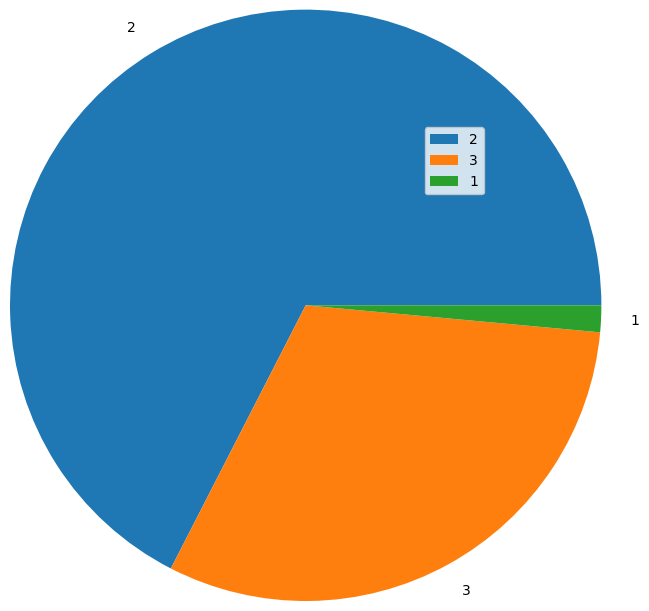

In [19]:
plt.pie(dataset["Regular_fiber_diet"].value_counts(),labels=["2","3","1"],
       radius=2)
plt.legend()
plt.show()

- ### Diagnostic_in_family_history

In [20]:
family_history=dataset["Diagnostic_in_family_history"]

Fiind o variabila categorica binara, sa facem o histograma

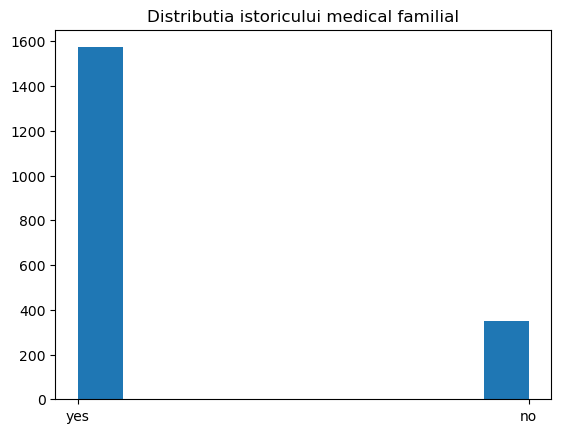

In [21]:
family_history.hist(grid=False)
plt.title("Distributia istoricului medical familial")
plt.show()

In [22]:
dataset["Diagnostic_in_family_history"].replace({"yes":1,"no":0},inplace=True)

- ### High_calorie_diet

In [23]:
high_cals=dataset["High_calorie_diet"]

In [24]:
high_cals.unique()

array(['no', 'yes'], dtype=object)

Facem o histograma a acestei variabile categorice binare

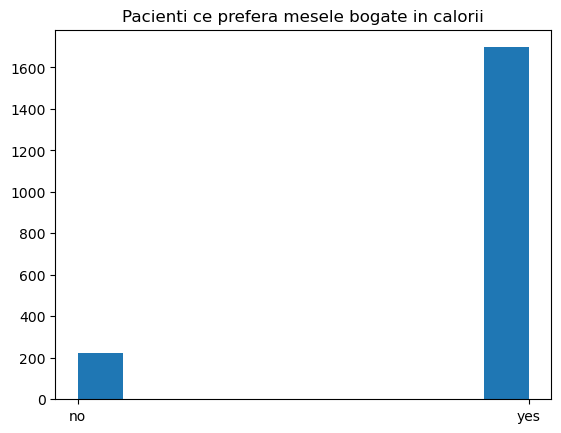

In [25]:
high_cals.hist(grid=False)
plt.title("Pacienti ce prefera mesele bogate in calorii")
plt.show()

In [26]:
dataset["High_calorie_diet"].replace({"yes":1,"no":0},inplace=True)

- ### Sedentary_hours_daily

In [27]:
sedentary=dataset["Sedentary_hours_daily"].apply(lambda s: re.sub(",",".",s)).astype(float)
dataset["Sedentary_hours_daily"]=sedentary

La prima vedere pare ca avem de-a face o valoare numerica. Am facut conversia de la . la , pentru a putea face statistici

In [28]:
sedentary.unique()

array([  3.73,   2.92,   3.85,   3.01,   2.73,   3.12,   3.09,   3.53,
         3.04,   4.47,   3.9 ,   2.78,   3.6 ,   3.37,   3.45,   2.86,
         2.21,   2.94,   4.44,   2.97,   3.1 ,   4.29,   3.57,   3.91,
         4.56,   3.22,   3.  ,   4.31,   2.68,   3.34,   2.29,   4.42,
         2.81,   2.23,   3.13,   3.14,   3.07,   3.28,   2.25,   2.31,
         2.32,   3.75,   3.18,   3.4 ,   2.99,   3.03,   4.08,   3.26,
         3.88,   3.47,   2.45,   3.83,   4.16,   3.5 ,   2.56,   3.06,
         3.58,   2.77,   3.19,   3.15,   2.38,   2.7 ,   2.93,   3.69,
         2.67,   3.93,   2.41,   2.95,   2.35,   2.55,   3.35,   2.63,
         2.72,   2.26,   3.29,   3.78,   3.08,   3.66,   2.6 ,   2.57,
         2.59,   3.42,   4.13,   3.41,   3.31,   4.38,   3.21,   4.15,
         3.11,   2.58,   3.65,   4.1 ,   2.24,   4.43,   3.76,   2.37,
         2.8 ,   2.91,   3.17,   2.65,   2.46,   4.61,   4.46,   2.85,
         3.48,   2.51,   2.49,   2.34,   4.11,   2.53,   2.48,   2.47,
      

In [29]:
sedentary.value_counts()

Sedentary_hours_daily
3.09    26
3.06    24
3.01    23
3.03    22
3.14    21
        ..
4.36     1
3.99     1
4.63     1
4.07     1
4.67     1
Name: count, Length: 239, dtype: int64

In [30]:
sedentary.value_counts()[956.58]

1

In [31]:
dataset=dataset[dataset["Sedentary_hours_daily"]!=956.58]

In [32]:
dataset["Sedentary_hours_daily"].describe()

count    1920.000000
mean        3.197276
std         0.575756
min         2.210000
25%         2.770000
50%         3.130000
75%         3.640000
max         4.670000
Name: Sedentary_hours_daily, dtype: float64

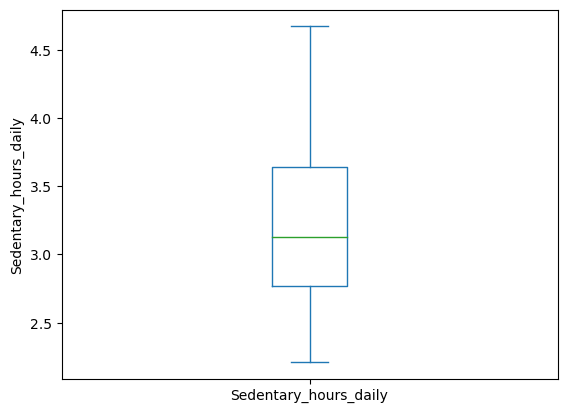

In [33]:
dataset["Sedentary_hours_daily"].plot.box()
plt.ylabel("Sedentary_hours_daily")
plt.show()

Box plot-ul este, din pacate foarte mic, dar se vede totusi un outlier destul de interesant, ce pare a fi cel corespunzator maximului, si anume de 956,58

In [34]:
IQR=dataset["Sedentary_hours_daily"].describe()["75%"]-dataset["Sedentary_hours_daily"].describe()["25%"]
IQR

0.8700000000000001

- ### Age

In [35]:
age=dataset["Age"]

Valori unice

In [36]:
age.unique()

array(['21', '23', '27', ..., '22,524036', '24,361936', '23,664709'],
      dtype=object)

Facem putina preprocesare pentru a scoate virgula

In [37]:
age_ints=age.apply(lambda s:re.sub(",","",s)).astype(int)
dataset["Age"]=age_ints

In [38]:
age_ints.unique()

array([      21,       23,       27, ..., 22524036, 24361936, 23664709])

Pare ca exista niste outlieri in varsta, drept pentru care facem o sortare ca sa ne dam seama ce se intampla

In [39]:
sorted_by_age=age_ints.value_counts().sort_index()
sorted_by_age

Age
15            1
16            7
17           28
18          116
19           51
           ... 
46491859      1
47283374      1
50832559      1
55022494      1
55137881      1
Name: count, Length: 1282, dtype: int64

In [40]:
sorted_by_age.index[:100]

Index([     15,      16,      17,      18,      19,      20,      21,      22,
            23,      24,      25,      26,      27,      28,      29,      30,
            31,      32,      33,      34,      35,      36,      37,      38,
            39,      40,      41,      44,      45,      51,      52,      55,
            56,      61,   19627,   19685,  176739,  203756,  209859,  210285,
        213928,  216548,  240409,  245822,  252984,  253292,  330816,  477061,
       1630687, 1638009, 1706713, 1708525, 1725813, 1770368, 1804892, 1810682,
       1813782, 1820634, 1848207, 1853084, 1883919, 1888061, 1888485, 1891505,
       1894093, 1916097, 1917614, 1921164, 1921638, 1947219, 1947554, 1959904,
       1972925, 1986997, 1988036, 1994814, 1996247, 1997166, 1997981, 2031094,
       2070768, 2081158, 2100829, 2101245, 2102064, 2102497, 2120563, 2128253,
       2167315, 2167447, 2172127, 2172738, 2181119, 2182165, 2190012, 2195994,
       2218881, 2239251, 2277789, 2287795],
      dt

In [41]:
abnormal_ages=dataset[dataset["Age"]>61]
abnormal_ages

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
457,Public_Transportation,3,1,1,3.14,25196214,Sometimes,1654,3,Sometimes,"1,69",no,"1,152736",no,-1,"0,319156",1,Female,D6
458,Public_Transportation,3,1,1,3.81,18503343,Sometimes,2152,3,Sometimes,"1,68",no,"1,115967",no,"126,67378","1,541072",1,Female,D6
460,Public_Transportation,3,1,1,3.17,21853826,Sometimes,2622,3,Sometimes,"1,76",no,"2,184707",no,-1,"1,978631",1,Female,D6
461,Public_Transportation,3,1,1,2.39,2190012,Sometimes,1555,3,Sometimes,"1,84",no,"2,406541",no,"165,057269","0,10032",0,Female,D6
462,Public_Transportation,3,1,1,3.64,18306615,Sometimes,1734,3,Sometimes,"1,75",no,"2,984323",no,"133,03441","1,586525",1,Female,D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,Public_Transportation,3,1,1,3.08,20976842,Sometimes,2744,3,Sometimes,"1,71",no,"1,728139",no,"131,408528","1,676269",1,Female,D6
1917,Public_Transportation,3,1,1,3.00,21982942,Sometimes,2977,3,Sometimes,"1,75",no,"2,00513",no,"133,742943","1,34139",1,Female,D6
1918,Public_Transportation,3,1,1,3.26,22524036,Sometimes,2422,3,Sometimes,"1,75",no,"2,054193",no,"133,689352","1,414209",1,Female,D6
1919,Public_Transportation,3,1,1,3.61,24361936,Sometimes,2372,3,Sometimes,"1,74",no,"2,852339",no,"133,346641","1,139107",1,Female,D6


In [42]:
indices_abnormal_ages=abnormal_ages.index.to_list()
abnormal_ages_intervals=make_intervals(indices_abnormal_ages)

In [43]:
dataset.loc[indices_abnormal_ages,"Age"]=-1

In [44]:
new_ages=np.zeros(len(dataset))
for left_side,right_side in abnormal_ages_intervals:
    index=left_side
    for new_row in avgImputer.fit_transform(dataset.loc[0:right_side+1,"Age"].to_numpy().reshape(-1,1))[left_side:right_side+1]:
        new_ages[index]=math.floor(new_row[0])
        index+=1

In [45]:
dataset.loc[:,"Age"]=new_ages

In [46]:
dataset["Age"].describe()

count    1920.000000
mean       22.489062
std         3.651991
min        15.000000
25%        22.000000
50%        22.000000
75%        23.000000
max        61.000000
Name: Age, dtype: float64

1.0


<AxesSubplot:>

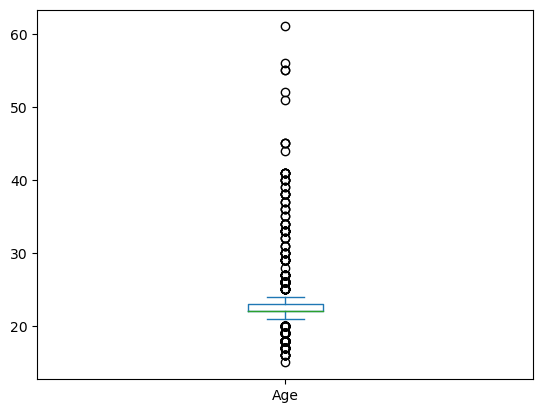

In [47]:
IQR=dataset["Age"].describe()["75%"]-dataset["Age"].describe()["25%"]
print(IQR)
dataset["Age"].plot.box()

- ### Alcohol

In [48]:
alcohol=dataset["Alcohol"]

In [49]:
alcohol.unique()

array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

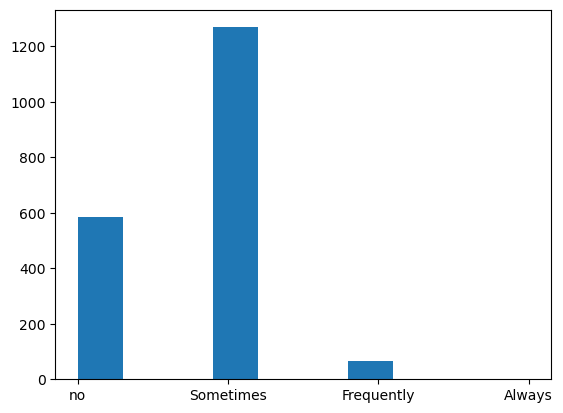

In [50]:
alcohol.hist(grid=False)
plt.show()

In [51]:
dataset["Alcohol"].replace({"no":0,"Sometimes":1,"Frequently":2,"Always":3},inplace=True)

- ### Est_avg_calorie_intake

In [52]:
avg_calorie=dataset["Est_avg_calorie_intake"]
avg_calorie.unique()

array([2474, 2429, 2656, ..., 2778, 1747, 2372], dtype=int64)

In [53]:
np.sort(avg_calorie.unique())

array([1500, 1501, 1502, ..., 2996, 2998, 3000], dtype=int64)

In [54]:
avg_calorie_stats=avg_calorie.describe()
avg_calorie_stats

count    1920.000000
mean     2253.405208
std       434.012263
min      1500.000000
25%      1870.250000
50%      2252.500000
75%      2628.000000
max      3000.000000
Name: Est_avg_calorie_intake, dtype: float64

In [55]:
avg_calorie_stats["75%"]-avg_calorie_stats["25%"]

757.75

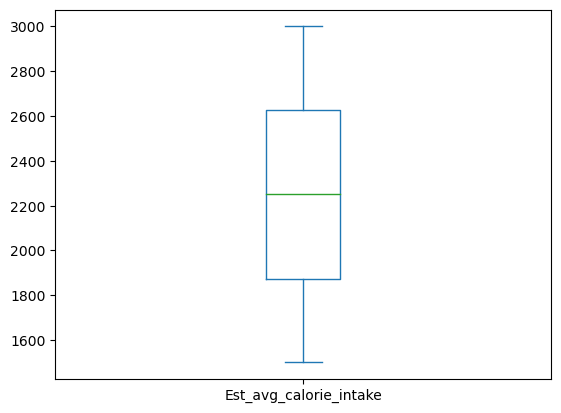

In [56]:
avg_calorie.plot.box()
plt.show()

- ### Main_meals_daily

In [57]:
meals=dataset["Main_meals_daily"]
meals.unique()

array(['3', '1', '4', '3,28926', '3,995147', '2,581015', '1,600812',
       '1,73762', '1,10548', '2,0846', '2,857787', '3,765526', '3,285167',
       '3,691226', '3,156153', '1,07976', '3,559841', '3,891994',
       '3,240578', '3,904858', '3,11158', '3,590039', '2,057935',
       '3,558637', '2,000986', '3,821168', '3,897078', '3,092116',
       '3,286431', '3,592415', '3,754599', '3,566082', '3,725797',
       '3,520555', '3,731212', '1,259803', '1,273128', '3,647154',
       '3,300666', '3,535016', '1,717608', '2,884479', '3,626815',
       '3,16645', '3,494849', '2,99321', '2,127797', '3,90779',
       '3,699594', '3,179995', '3,238258', '3,804944', '1,630846',
       '3,762778', '2,705445', '3,34175', '2,217651', '2,893778',
       '3,502604', '3,998766', '3,193671', '1,69608', '2,812377',
       '1,612747', '1,082304', '1,882158', '2,326233', '1,989398',
       '1,735493', '3,715118', '3,489918', '3,378859', '3,263201',
       '3,994588', '3,24934', '3,087544', '1,163666', '3,40

Se constata prezenta de date anormale pentru aceasta variabila categorica

In [58]:
meals=meals.apply(lambda s:re.sub(",","",s)).astype(int)
meals.unique()

array([      3,       1,       4,  328926, 3995147, 2581015, 1600812,
        173762,  110548,   20846, 2857787, 3765526, 3285167, 3691226,
       3156153,  107976, 3559841, 3891994, 3240578, 3904858,  311158,
       3590039, 2057935, 3558637, 2000986, 3821168, 3897078, 3092116,
       3286431, 3592415, 3754599, 3566082, 3725797, 3520555, 3731212,
       1259803, 1273128, 3647154, 3300666, 3535016, 1717608, 2884479,
       3626815,  316645, 3494849,  299321, 2127797,  390779, 3699594,
       3179995, 3238258, 3804944, 1630846, 3762778, 2705445,  334175,
       2217651, 2893778, 3502604, 3998766, 3193671,  169608, 2812377,
       1612747, 1082304, 1882158, 2326233, 1989398, 1735493, 3715118,
       3489918, 3378859, 3263201, 3994588,  324934, 3087544, 1163666,
       3409363, 3281391,  398525, 3471536, 3488342, 3443456,  303779,
       3642802, 2645858, 3420618,  264155, 3887906, 3435905, 3747163,
       2625475, 3098399,  312544,  396981, 3712183, 3832911, 3576103,
        356544, 3266

In [59]:
dataset.loc[:,"Main_meals_daily"]=meals

In [60]:
dataset["Main_meals_daily"].unique()

array([3, 1, 4, 328926, 3995147, 2581015, 1600812, 173762, 110548, 20846,
       2857787, 3765526, 3285167, 3691226, 3156153, 107976, 3559841,
       3891994, 3240578, 3904858, 311158, 3590039, 2057935, 3558637,
       2000986, 3821168, 3897078, 3092116, 3286431, 3592415, 3754599,
       3566082, 3725797, 3520555, 3731212, 1259803, 1273128, 3647154,
       3300666, 3535016, 1717608, 2884479, 3626815, 316645, 3494849,
       299321, 2127797, 390779, 3699594, 3179995, 3238258, 3804944,
       1630846, 3762778, 2705445, 334175, 2217651, 2893778, 3502604,
       3998766, 3193671, 169608, 2812377, 1612747, 1082304, 1882158,
       2326233, 1989398, 1735493, 3715118, 3489918, 3378859, 3263201,
       3994588, 324934, 3087544, 1163666, 3409363, 3281391, 398525,
       3471536, 3488342, 3443456, 303779, 3642802, 2645858, 3420618,
       264155, 3887906, 3435905, 3747163, 2625475, 3098399, 312544,
       396981, 3712183, 3832911, 3576103, 356544, 3266644, 3433908,
       3998618, 1226342, 10607

In [61]:
def treat_abnormalities(condition,imputer,type_var,attribute_name,must_be_discrete=False):
    contaminated_indexes=dataset[condition].index.to_list()
    intervals=make_intervals(contaminated_indexes)
    if(type_var=="numerical"):
        dataset.loc[contaminated_indexes,attribute_name]=-1
    else:
        dataset.loc[contaminated_indexes,attribute_name]='XX'
    new_values=np.zeros(len(dataset))
    for left_side,right_side in intervals:
        index=left_side
        for new_row in imputer.fit_transform(dataset.loc[0:right_side+1,attribute_name].to_numpy().reshape(-1,1))[left_side:right_side+1]:
            new_values[index]=new_row[0]
            if(must_be_discrete):
                new_values[index]=math.floor(new_values[index])
            index+=1
    dataset.loc[:,attribute_name]=new_values

In [62]:
treat_abnormalities(dataset["Main_meals_daily"]>4,modeImputer,"categorical","Main_meals_daily",False)

In [63]:
dataset["Main_meals_daily"].unique()

array([3.0, 1.0, 4.0], dtype=object)

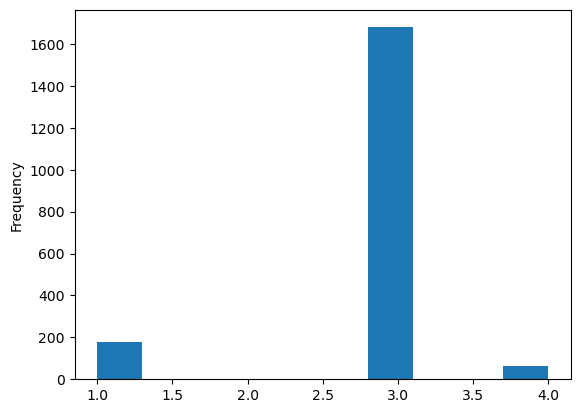

In [64]:
dataset["Main_meals_daily"].plot.hist()
plt.show()

- ### Snacks

In [65]:
snacks=dataset["Snacks"]

In [66]:
snacks.unique()

array(['Sometimes', 'Frequently', 'Always', 'no'], dtype=object)

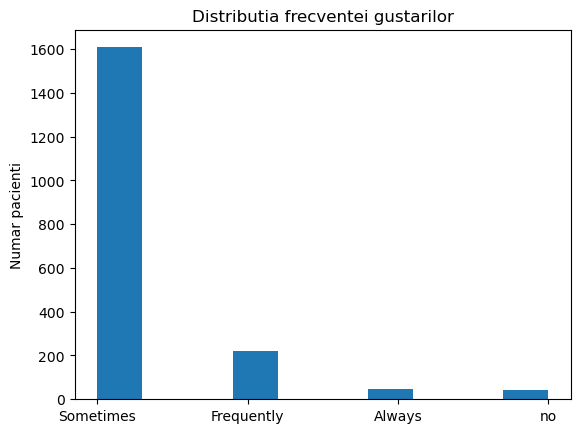

In [67]:
snacks.hist(grid=False)
plt.ylabel("Numar pacienti")
plt.title("Distributia frecventei gustarilor")
plt.show()

In [68]:
dataset["Snacks"].replace({"no":0,"Sometimes":1,"Frequently":2,"Always":3},inplace=True)

- ### Height

In [69]:
height=dataset["Height"]

In [70]:
height.unique()

array(['1,62', '1,52', '1,8', '1,78', '1,5', '1,72', '1,85', '1,65',
       '1,77', '1,7', '1,93', '1,53', '1,71', '1,69', '1,6', '1,75',
       '1,68', '1,58', '1,79', '1,56', '1,67', '1,66', '1,55', '1,61',
       '1,64', '1,63', '1,76', '1,82', '1,57', '1,88', '1,87', '1,89',
       '1,74', '1,83', '1,92', '1,73', '1,84', '1,91', '1,48', '1,59',
       '1,54', '1,9', '1,45', '1,98', '1,51', '1,81', '1,86', '1,46',
       '1,49', '1,94', '1683', '1915'], dtype=object)

In [71]:
new_heights=height.apply(lambda s: re.sub(",",".",s)).astype(float)
new_heights

0       1.62
1       1.52
2       1.80
3       1.80
4       1.78
        ... 
1916    1.71
1917    1.75
1918    1.75
1919    1.74
1920    1.74
Name: Height, Length: 1920, dtype: float64

In [72]:
dataset.loc[:,"Height"]=new_heights

In [73]:
dataset["Height"].unique()

array([1.62, 1.52, 1.8, 1.78, 1.5, 1.72, 1.85, 1.65, 1.77, 1.7, 1.93,
       1.53, 1.71, 1.69, 1.6, 1.75, 1.68, 1.58, 1.79, 1.56, 1.67, 1.66,
       1.55, 1.61, 1.64, 1.63, 1.76, 1.82, 1.57, 1.88, 1.87, 1.89, 1.74,
       1.83, 1.92, 1.73, 1.84, 1.91, 1.48, 1.59, 1.54, 1.9, 1.45, 1.98,
       1.51, 1.81, 1.86, 1.46, 1.49, 1.94, 1683.0, 1915.0], dtype=object)

In [74]:
treat_abnormalities(dataset["Height"]==1683.0,avgImputer,"numerical","Height",False)

In [75]:
treat_abnormalities(dataset["Height"]==1915.0,avgImputer,"numerical","Height",False)

In [76]:
dataset["Height"].unique()

array([1.62, 1.52, 1.8, 1.78, 1.5, 1.72, 1.85, 1.65, 1.77, 1.7, 1.93,
       1.53, 1.71, 1.69, 1.6, 1.75, 1.68, 1.58, 1.79, 1.56, 1.67, 1.66,
       1.55, 1.61, 1.64, 1.63, 1.76, 1.82, 1.57, 1.88, 1.87, 1.89, 1.74,
       1.83, 1.92, 1.73, 1.84, 1.91, 1.48, 1.59, 1.54, 1.9, 1.45, 1.98,
       1.51, 1.81, 1.86, 1.46, 1.49, 1.94, 1.6911312217194567,
       1.6997315372434139], dtype=object)

In [77]:
dataset["Height"]=dataset["Height"].astype(float)

In [78]:
dataset["Height"].describe()

count    1920.000000
mean        1.702297
std         0.093224
min         1.450000
25%         1.630000
50%         1.700000
75%         1.770000
max         1.980000
Name: Height, dtype: float64

In [79]:
IQR=dataset["Height"].describe()["75%"]-dataset["Height"].describe()["25%"]
IQR

0.14000000000000012

- ### Smoker

In [80]:
dataset["Smoker"].unique()

array(['no', 'yes'], dtype=object)

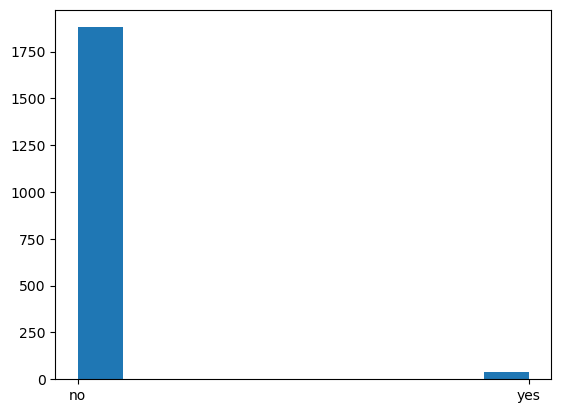

In [81]:
dataset["Smoker"].hist(grid=False)
plt.show()

In [82]:
dataset["Smoker"].replace({"yes":1,"no":0},inplace=True)

- ### Water_daily

In [83]:
dataset["Water_daily"].unique()

array(['2', '3', '1', ..., '2,054193', '2,852339', '2,863513'],
      dtype=object)

In [84]:
new_water=dataset["Water_daily"].apply(lambda s: re.sub(r",","",s)).astype(int)
dataset.loc[:,"Water_daily"]=new_water

In [85]:
np.sort(dataset["Water_daily"].unique())[:10]

array([1, 2, 3, 12751, 13954, 15197, 16213, 18924, 27305, 101378],
      dtype=object)

In [86]:
treat_abnormalities(dataset["Water_daily"]>3,modeImputer,"categorical","Water_daily",False)

In [87]:
dataset["Water_daily"].unique()

array([2.0, 3.0, 1.0], dtype=object)

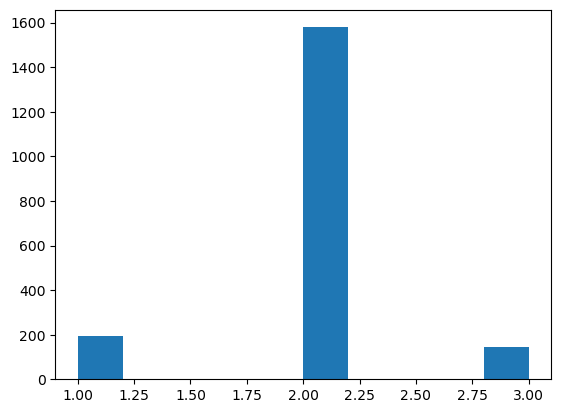

In [88]:
dataset["Water_daily"].hist(grid=False)
plt.show()

- ### Calorie_monitoring

In [89]:
dataset["Calorie_monitoring"].unique()

array(['no', 'yes'], dtype=object)

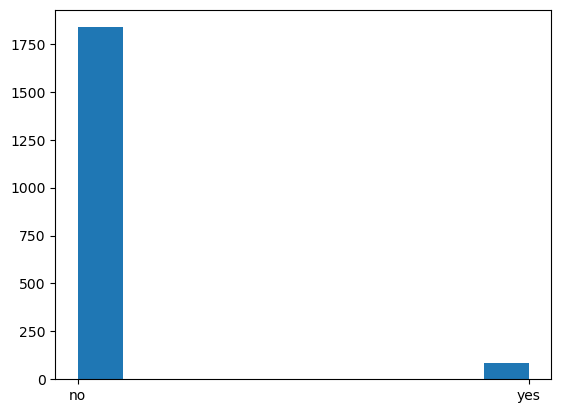

In [90]:
dataset["Calorie_monitoring"].hist(grid=False)
plt.show()

In [91]:
dataset.replace({"yes":1,"no":0},inplace=True)

- ### Weight

In [92]:
dataset["Weight"].unique()

array(['64', '56', '77', ..., '133,689352', '133,346641', '133,472641'],
      dtype=object)

In [93]:
new_weights=dataset["Weight"].apply(lambda s: float(re.sub(r",",".",s)) if s!='-1' else -1)
dataset.loc[:,"Weight"]=new_weights

In [94]:
treat_abnormalities(dataset["Weight"]==-1,avgImputer,"numerical","Weight",False)

<AxesSubplot:>

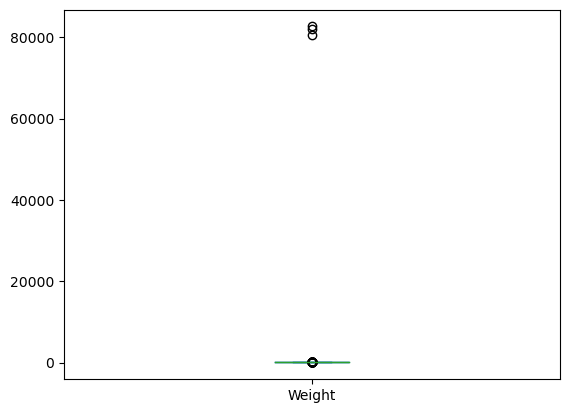

In [95]:
dataset["Weight"].plot.box()

In [96]:
dataset["Weight"].astype(float).describe()

count     1920.000000
mean       219.709445
std       3225.965542
min         39.000000
25%         66.739474
50%         83.364352
75%        110.817784
max      82628.000000
Name: Weight, dtype: float64

In [97]:
treat_abnormalities(dataset["Weight"]>300.0,avgImputer,"numerical","Weight",False)

<AxesSubplot:>

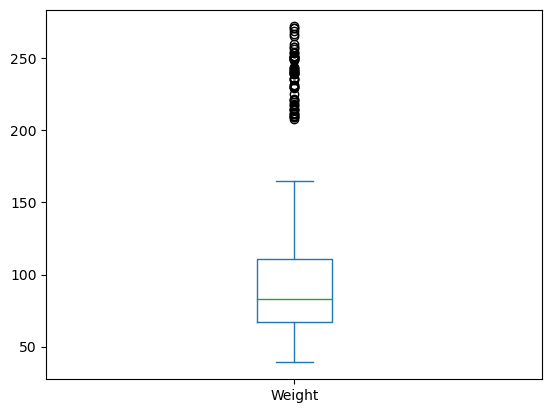

In [98]:
dataset["Weight"].plot.box()

<AxesSubplot:>

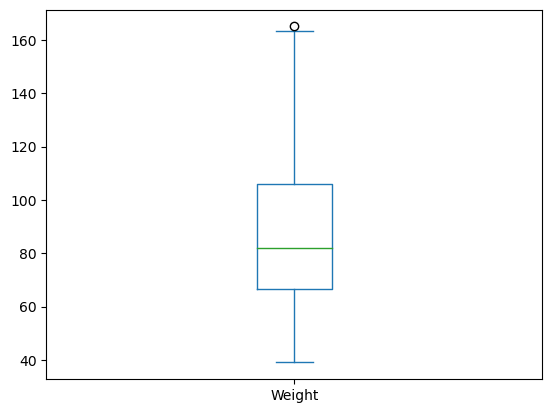

In [99]:
treat_abnormalities(dataset["Weight"]>200.0,avgImputer,"numerical","Weight",False)
dataset["Weight"].plot.box()

In [100]:
dataset["Weight"].astype(float).describe()

count    1920.000000
mean       86.582119
std        26.596913
min        39.000000
25%        66.739474
50%        82.015473
75%       105.984787
max       165.057269
Name: Weight, dtype: float64

<AxesSubplot:>

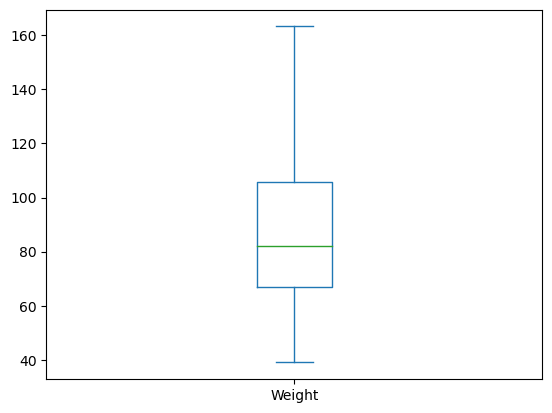

In [101]:
treat_abnormalities(dataset["Weight"]>165,avgImputer,"numerical","Weight",False)
dataset["Weight"].plot.box()

In [102]:
dataset["Weight"].astype(float).describe()

count    1920.000000
mean       86.532428
std        26.539283
min        39.000000
25%        66.739474
50%        82.012299
75%       105.841842
max       163.249211
Name: Weight, dtype: float64

In [103]:
IQR=dataset["Weight"].astype(float).describe()["75%"]-dataset["Weight"].astype(float).describe()["25%"]
IQR

39.102368

- ### Physical_activity_level

In [104]:
dataset["Physical_activity_level"].unique()

array(['0', '3', '2', ..., '1,414209', '1,139107', '1,026452'],
      dtype=object)

In [105]:
new_phys_label=dataset["Physical_activity_level"].apply(lambda s: re.sub(r",","",s)).astype(int)
dataset.loc[:,"Physical_activity_level"]=new_phys_label

In [106]:
np.sort(new_phys_label.unique())[:10]

array([  0,   1,   2,   3,  96, 203, 272, 342, 454, 705])

In [107]:
treat_abnormalities(dataset["Physical_activity_level"]>3,modeImputer,"categorical","Physical_activity_level",False)

In [108]:
dataset["Physical_activity_level"].unique()

array([0.0, 3.0, 2.0, 1.0], dtype=object)

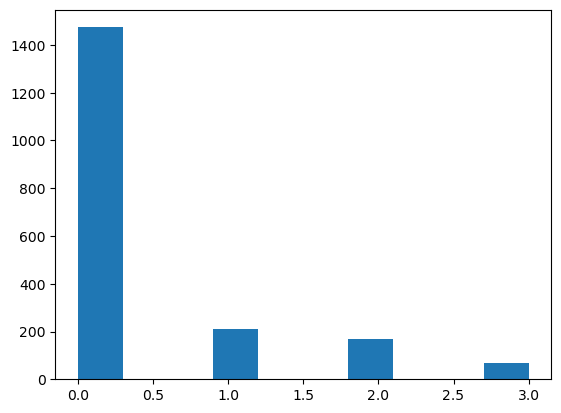

In [109]:
dataset["Physical_activity_level"].hist(grid=False)
plt.show()

- ### Technology_time_use

In [110]:
dataset["Technology_time_use"].unique()

array([1, 0, 2], dtype=int64)

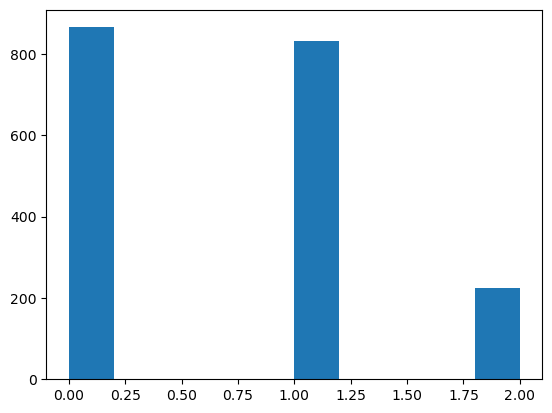

In [111]:
dataset["Technology_time_use"].hist(grid=False)
plt.show()

- ### Gender

In [112]:
dataset["Gender"].unique()

array(['Female', 'Male'], dtype=object)

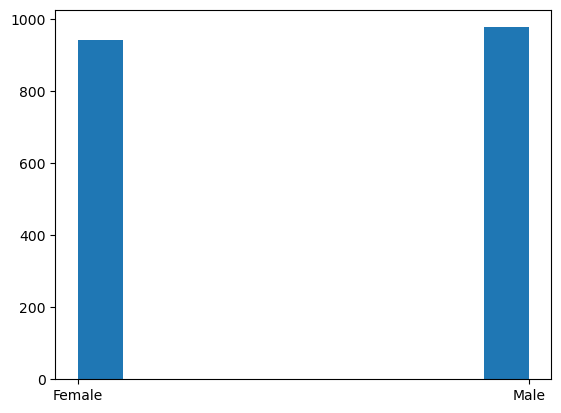

In [113]:
dataset["Gender"].hist(grid=False)
plt.show()

# Clasa ce trebuie prezisa - Diagnostic

In [114]:
dataset["Diagnostic"].unique()

array(['D1', 'D2', 'D3', 'D4', 'D0', 'D5', 'D6'], dtype=object)

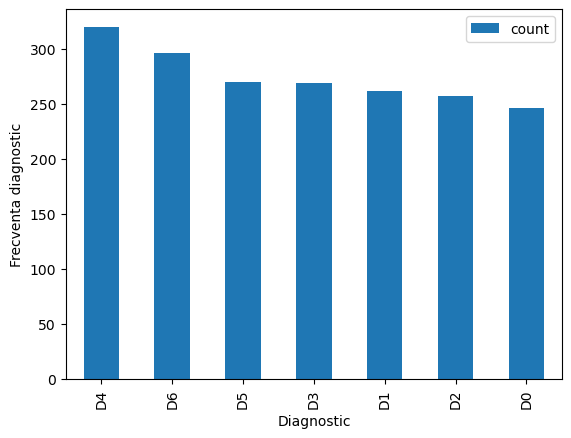

In [115]:
pd.DataFrame(dataset["Diagnostic"].value_counts()).plot.bar()
plt.ylabel("Frecventa diagnostic")
plt.show()

In [116]:
dataset.replace({"D0":0,"D1":1,"D2":2,"D3":3,"D4":4,"D5":5,"D6":6},inplace=True)

## Covarianta atributelor

In [117]:
dataset

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
0,Public_Transportation,2,1,0,3.73,21,0,2474,3.0,1,1.62,0,2.0,0,64.000000,0.0,1,Female,1
1,Public_Transportation,3,1,0,2.92,21,1,2429,3.0,1,1.52,1,3.0,1,56.000000,3.0,0,Female,1
2,Public_Transportation,2,1,0,3.85,23,2,2656,3.0,1,1.80,0,2.0,0,77.000000,2.0,1,Male,1
3,Walking,3,0,0,3.01,27,2,2260,3.0,1,1.80,0,2.0,0,71.700000,2.0,0,Male,2
4,Public_Transportation,2,0,0,2.73,22,1,1895,1.0,1,1.78,0,2.0,0,89.800000,0.0,0,Male,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,Public_Transportation,3,1,1,3.08,23,1,2744,3.0,1,1.71,0,2.0,0,131.408528,0.0,1,Female,6
1917,Public_Transportation,3,1,1,3.00,23,1,2977,3.0,1,1.75,0,2.0,0,133.742943,0.0,1,Female,6
1918,Public_Transportation,3,1,1,3.26,23,1,2422,3.0,1,1.75,0,2.0,0,133.689352,0.0,1,Female,6
1919,Public_Transportation,3,1,1,3.61,23,1,2372,3.0,1,1.74,0,2.0,0,133.346641,0.0,1,Female,6


In [118]:
new_transportation=OrdinalEncoder().fit_transform(dataset["Transportation"].to_numpy().reshape(-1,1))
dataset.loc[:,"Transportation"]=new_transportation

In [119]:
ord_enc=OrdinalEncoder()

In [120]:
dataset.loc[:,"Gender"]=ord_enc.fit_transform(dataset["Gender"].to_numpy().reshape(-1,1))

In [121]:
dataset.corr()

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Height,Smoker,Water_daily,Calorie_monitoring,Weight,Physical_activity_level,Technology_time_use,Gender,Diagnostic
Transportation,1.000000,0.157949,-0.099996,-0.072539,0.139600,-0.181074,0.024129,0.014332,-0.105175,0.044093,-0.077044,-0.009033,0.029567,0.033569,-0.001065,0.020417,0.170513,-0.138235,0.012614
Regular_fiber_diet,0.157949,1.000000,0.011457,-0.045313,-0.057646,0.128077,0.142114,-0.014232,-0.003245,0.077487,-0.067710,0.016050,0.016561,0.086161,0.203269,0.004639,-0.071270,-0.355877,0.249408
Diagnostic_in_family_history,-0.099996,0.011457,1.000000,0.199630,0.022366,0.037473,-0.032687,-0.041374,0.135410,-0.175068,0.246172,0.011833,0.125730,-0.159261,0.471279,-0.240608,0.025673,0.100285,0.504692
High_calorie_diet,-0.072539,-0.045313,0.199630,1.000000,0.075933,-0.092185,0.087060,0.019768,0.007109,-0.146350,0.179557,-0.060583,-0.033619,-0.186010,0.245851,-0.224175,0.060603,0.068098,0.243489
Sedentary_hours_daily,0.139600,-0.057646,0.022366,0.075933,1.000000,-0.137287,-0.044669,0.017743,0.058870,0.029353,0.050546,0.008103,0.057769,-0.021640,-0.034284,0.007013,0.865755,0.001613,-0.072140
Age,-0.181074,0.128077,0.037473,-0.092185,-0.137287,1.000000,0.100603,-0.010835,-0.049825,0.042246,-0.055687,0.142265,-0.001030,0.000987,0.070072,-0.012666,-0.165778,-0.074709,0.123400
Alcohol,0.024129,0.142114,-0.032687,0.087060,-0.044669,0.100603,1.000000,0.002224,-0.008178,-0.046089,0.132737,0.082706,0.049785,0.006457,0.159337,-0.057361,-0.034652,-0.010922,0.149777
Est_avg_calorie_intake,0.014332,-0.014232,-0.041374,0.019768,0.017743,-0.010835,0.002224,1.000000,-0.011111,-0.002823,-0.054224,-0.042074,-0.014941,-0.013874,-0.035913,0.009344,0.008607,-0.025783,-0.037949
Main_meals_daily,-0.105175,-0.003245,0.135410,0.007109,0.058870,-0.049825,-0.008178,-0.011111,1.000000,0.047084,0.226058,-0.022933,0.035158,-0.017833,0.162320,0.020284,0.056153,0.119375,0.112517
Snacks,0.044093,0.077487,-0.175068,-0.146350,0.029353,0.042246,-0.046089,-0.002823,0.047084,1.000000,-0.052762,0.064889,-0.151473,0.110772,-0.275814,0.186127,0.043836,-0.092620,-0.326052


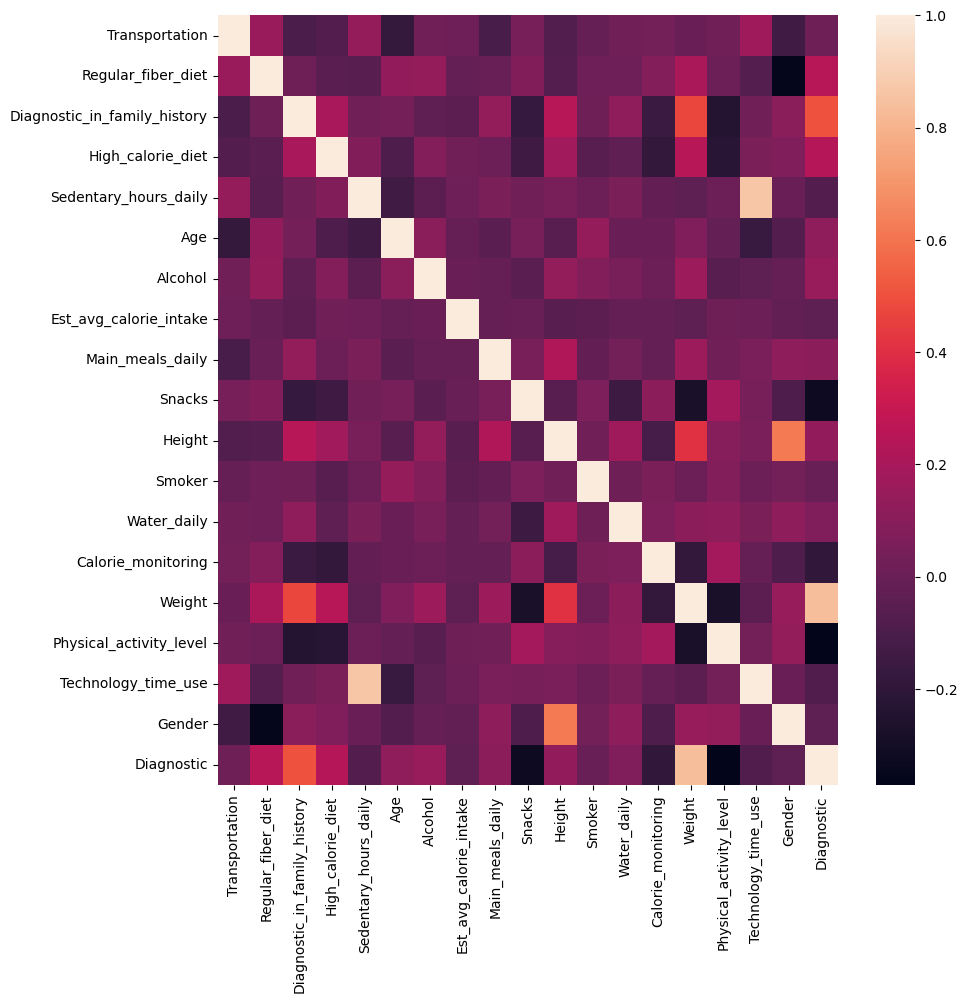

In [122]:
plt.figure(figsize=(10,10))
sns.heatmap(dataset.corr())
plt.show()

- ## Selectia atributelor: Variance Threshold

In [123]:
features=dataset.iloc[:,:-1].to_numpy()
labels=dataset.iloc[:,-1].to_numpy()

In [124]:
variance_threshold=VarianceThreshold(threshold=0.1025)
variance_threshold.fit(features)
new_features_indexes=variance_threshold.get_support(indices=True)
new_dataset=dataset.iloc[:,new_features_indexes]
#print(dataset.columns[new_features_indexes])
all_features_indexes=np.arange(0,features.shape[1])
excluded_feature_indexes=np.array(list(set(all_features_indexes)-set(new_features_indexes)))
print("Excluded features",dataset.columns[excluded_feature_indexes])
print("Correlation of excluded features with the target variable")
for col in dataset.columns[excluded_feature_indexes]:
    print("Corr between Diagnostic and {} is {}".format(col,dataset.corr()["Diagnostic"][col]))
print("Considered columns for prediction: ",dataset.columns[new_features_indexes])
#new_dataset.to_numpy()
train_val_features,test_features,train_val_y,test_y=train_test_split(new_dataset.to_numpy(),labels,
                                                                     random_state=42,test_size=0.2)

Excluded features Index(['Height', 'Smoker', 'Calorie_monitoring'], dtype='object')
Correlation of excluded features with the target variable
Corr between Diagnostic and Height is 0.13019007655111536
Corr between Diagnostic and Smoker is -0.005093486025003062
Corr between Diagnostic and Calorie_monitoring is -0.18964450668598895
Considered columns for prediction:  Index(['Transportation', 'Regular_fiber_diet', 'Diagnostic_in_family_history',
       'High_calorie_diet', 'Sedentary_hours_daily', 'Age', 'Alcohol',
       'Est_avg_calorie_intake', 'Main_meals_daily', 'Snacks', 'Water_daily',
       'Weight', 'Physical_activity_level', 'Technology_time_use', 'Gender'],
      dtype='object')


In [125]:
new_dataset

,Transportation,Regular_fiber_diet,Diagnostic_in_family_history,High_calorie_diet,Sedentary_hours_daily,Age,Alcohol,Est_avg_calorie_intake,Main_meals_daily,Snacks,Water_daily,Weight,Physical_activity_level,Technology_time_use,Gender
0,3.0,2,1,0,3.73,21,0,2474,3.0,1,2.0,64.000000,0.0,1,0.0
1,3.0,3,1,0,2.92,21,1,2429,3.0,1,3.0,56.000000,3.0,0,0.0
2,3.0,2,1,0,3.85,23,2,2656,3.0,1,2.0,77.000000,2.0,1,1.0
3,4.0,3,0,0,3.01,27,2,2260,3.0,1,2.0,71.700000,2.0,0,1.0
4,3.0,2,0,0,2.73,22,1,1895,1.0,1,2.0,89.800000,0.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1916,3.0,3,1,1,3.08,23,1,2744,3.0,1,2.0,131.408528,0.0,1,0.0
1917,3.0,3,1,1,3.00,23,1,2977,3.0,1,2.0,133.742943,0.0,1,0.0
1918,3.0,3,1,1,3.26,23,1,2422,3.0,1,2.0,133.689352,0.0,1,0.0
1919,3.0,3,1,1,3.61,23,1,2372,3.0,1,2.0,133.346641,0.0,1,0.0


In [126]:
standardized_features=StandardScaler().fit_transform(train_val_features)
standardized_features,train_val_y

(array([[ 0.49642675,  1.44037316, -2.1850483 , ..., -0.50287565,
         -1.00245883, -1.01310672],
        [-1.88394209,  1.44037316,  0.45765579, ...,  0.73101732,
         -1.00245883,  0.98706284],
        [-1.88394209,  1.44037316,  0.45765579, ...,  0.73101732,
          0.4738372 , -1.01310672],
        ...,
        [-1.88394209, -0.6176856 ,  0.45765579, ..., -0.50287565,
          0.4738372 , -1.01310672],
        [ 0.49642675, -0.6176856 ,  0.45765579, ..., -0.50287565,
          0.4738372 ,  0.98706284],
        [-1.88394209, -0.6176856 ,  0.45765579, ..., -0.50287565,
         -1.00245883,  0.98706284]]),
 array([0, 1, 1, ..., 2, 5, 4], dtype=int64))

In [142]:
standardized_test_features=StandardScaler().fit_transform(test_features)
standardized_test_features

array([[-1.74027285,  1.45561846,  0.52107886, ..., -0.45998491,
        -0.92652381, -1.03714786],
       [ 0.55880321, -0.56958983,  0.52107886, ..., -0.45998491,
        -0.92652381,  0.96418268],
       [ 0.55880321, -0.56958983,  0.52107886, ..., -0.45998491,
        -0.92652381, -1.03714786],
       ...,
       [ 0.55880321, -0.56958983, -1.91909532, ...,  0.95308873,
        -0.92652381,  0.96418268],
       [ 0.55880321, -0.56958983, -1.91909532, ..., -0.45998491,
         0.58104035,  0.96418268],
       [ 0.55880321, -0.56958983,  0.52107886, ..., -0.45998491,
        -0.92652381,  0.96418268]])

In [177]:
svm_class=SVC(random_state=42)
param_dict={
    'C':list(np.arange(0.1,1.5,0.1)),
    'kernel':['linear','rbf','poly','sigmoid']
}
grid_SVM=GridSearchCV(svm_class,param_grid=param_dict,scoring=['accuracy','f1_macro','precision_macro','recall_macro'],refit=False,return_train_score=True)
grid_SVM.fit(standardized_features,train_val_y)

F:\Anaconda_folder\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                               0.7000000000000001, 0.8, 0.9, 1.0, 1.1,
                               1.2000000000000002, 1.3000000000000003,
                               1.4000000000000001],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [178]:
table=pd.DataFrame.from_dict(grid_SVM.cv_results_)
def get_index_list(table):
    columns=[]
    columns.append(np.argwhere(np.array(table.columns)=="params")[0])
    for metric in ["accuracy","f1","recall","precision"]:
        if(metric=="accuracy"):
            tmp=["mean_test_{}".format(metric),"std_test_{}".format(metric)]
        else:
            tmp=["mean_test_{}_macro".format(metric),"std_test_{}_macro".format(metric)]
        for x in tmp:
            columns.extend(np.argwhere(np.array(table.columns)==x))
    indexes=np.array(columns).flatten()
    return indexes
indexes=get_index_list(table)
final_table=table.iloc[:,indexes]
final_table

,params,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,mean_test_recall_macro,std_test_recall_macro,mean_test_precision_macro,std_test_precision_macro
0,"{'C': 0.1, 'kernel': 'linear'}",0.695328,0.029655,0.683906,0.032502,0.693294,0.030358,0.695192,0.033622
1,"{'C': 0.1, 'kernel': 'rbf'}",0.620464,0.021148,0.596664,0.022106,0.615792,0.021064,0.657735,0.030955
2,"{'C': 0.1, 'kernel': 'poly'}",0.476564,0.020485,0.442577,0.020589,0.456377,0.020123,0.622949,0.067397
3,"{'C': 0.1, 'kernel': 'sigmoid'}",0.552750,0.018781,0.523108,0.022351,0.545805,0.018722,0.553722,0.041579
4,"{'C': 0.2, 'kernel': 'linear'}",0.708994,0.022869,0.700979,0.025177,0.707543,0.024024,0.710019,0.026383
5,"{'C': 0.2, 'kernel': 'rbf'}",0.648447,0.021824,0.635099,0.025377,0.645044,0.022296,0.656938,0.025113
6,"{'C': 0.2, 'kernel': 'poly'}",0.576837,0.022937,0.572216,0.020981,0.566025,0.023618,0.681741,0.024214
7,"{'C': 0.2, 'kernel': 'sigmoid'}",0.574883,0.024535,0.552298,0.023397,0.567605,0.023526,0.567038,0.028776
8,"{'C': 0.30000000000000004, 'kernel': 'linear'}",0.718104,0.022562,0.709323,0.025615,0.717038,0.023477,0.717466,0.026742
9,"{'C': 0.30000000000000004, 'kernel': 'rbf'}",0.681645,0.022353,0.675877,0.023309,0.680415,0.022418,0.690451,0.024761


In [179]:
final_table.iloc[:,1:].idxmax(axis=0)

mean_test_accuracy           53
std_test_accuracy            19
mean_test_f1_macro           53
std_test_f1_macro            19
mean_test_recall_macro       53
std_test_recall_macro        19
mean_test_precision_macro    53
std_test_precision_macro      2
dtype: int64

In [180]:
final_table.iloc[53].params

{'C': 1.4000000000000001, 'kernel': 'rbf'}

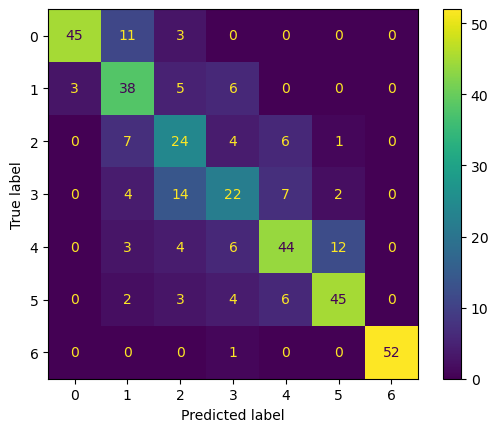

In [181]:
best_SVC=SVC(C=1.4,kernel='rbf')
best_SVC.fit(standardized_features,train_val_y)
y_pred=best_SVC.predict(standardized_test_features)
ConfusionMatrixDisplay(confusion_matrix(test_y,y_pred)).plot()
plt.show()

In [182]:
final_table.to_csv("SVM_results.csv")

In [170]:
random_forest=RandomForestClassifier(criterion='entropy',random_state=42)
rf_params={
    'n_estimators':np.arange(10,300,50),
    'max_depth':np.arange(2,9),
    'max_samples':list(np.arange(0.1,1.1,0.2))
}
rf_grid=GridSearchCV(random_forest,param_grid=rf_params,scoring=['accuracy','f1_macro','precision_macro','recall_macro'],refit=False,return_train_score=True)
rf_grid.fit(standardized_features,train_val_y)

F:\Anaconda_folder\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              random_state=42),
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8]),
                         'max_samples': [0.1, 0.30000000000000004,
                                         0.5000000000000001, 0.7000000000000001,
                                         0.9000000000000001],
                         'n_estimators': array([ 10,  60, 110, 160, 210, 260])},
             refit=False, return_train_score=True,
             scoring=['accuracy', 'f1_macro', 'precision_macro',
                      'recall_macro'])

In [171]:
rf_table=pd.DataFrame.from_dict(rf_grid.cv_results_)
rf_indexes=get_index_list(rf_table)
final_rf_table=rf_table.iloc[:,rf_indexes]
final_rf_table

,params,mean_test_accuracy,std_test_accuracy,mean_test_f1_macro,std_test_f1_macro,mean_test_recall_macro,std_test_recall_macro,mean_test_precision_macro,std_test_precision_macro
0,"{'max_depth': 2, 'max_samples': 0.1, 'n_estima...",0.503302,0.045510,0.447177,0.058632,0.493781,0.048721,0.510074,0.097249
1,"{'max_depth': 2, 'max_samples': 0.1, 'n_estima...",0.618493,0.024180,0.586784,0.026220,0.614056,0.022632,0.630669,0.034480
2,"{'max_depth': 2, 'max_samples': 0.1, 'n_estima...",0.617833,0.016423,0.581800,0.018963,0.615115,0.016055,0.646968,0.038702
3,"{'max_depth': 2, 'max_samples': 0.1, 'n_estima...",0.618484,0.016645,0.582694,0.016957,0.615056,0.016150,0.651183,0.018226
4,"{'max_depth': 2, 'max_samples': 0.1, 'n_estima...",0.619779,0.016678,0.580920,0.017231,0.617472,0.015498,0.641069,0.030177
...,...,...,...,...,...,...,...,...,...
205,"{'max_depth': 8, 'max_samples': 0.900000000000...",0.812513,0.016128,0.811035,0.016243,0.812825,0.015696,0.814591,0.014729
206,"{'max_depth': 8, 'max_samples': 0.900000000000...",0.806656,0.017837,0.804509,0.017391,0.806847,0.017620,0.807375,0.015470
207,"{'max_depth': 8, 'max_samples': 0.900000000000...",0.809260,0.020707,0.806986,0.020236,0.809494,0.020459,0.808685,0.018719
208,"{'max_depth': 8, 'max_samples': 0.900000000000...",0.810565,0.018826,0.808004,0.018613,0.810441,0.018555,0.811326,0.017607


In [172]:
final_rf_table.iloc[:,1:].idxmax(axis=0)

mean_test_accuracy           205
std_test_accuracy              0
mean_test_f1_macro           205
std_test_f1_macro              0
mean_test_recall_macro       205
std_test_recall_macro          0
mean_test_precision_macro    205
std_test_precision_macro       0
dtype: int64

In [175]:
final_rf_table.iloc[205].params

{'max_depth': 8, 'max_samples': 0.9000000000000001, 'n_estimators': 60}

In [174]:
final_rf_table.to_csv("RF_results.csv",index=True)

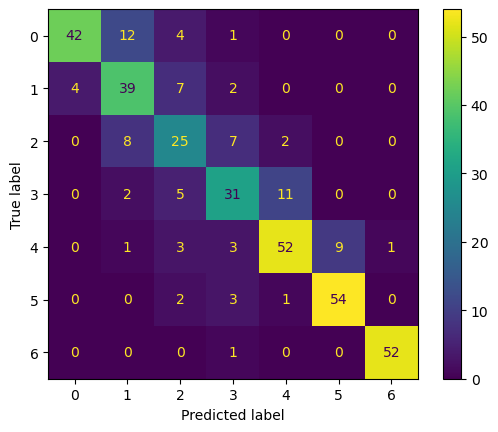

In [176]:
best_rf=RandomForestClassifier(max_depth=8,max_samples=0.9,n_estimators=60)
best_rf.fit(standardized_features,train_val_y)
y_pred=best_rf.predict(standardized_test_features)
ConfusionMatrixDisplay(confusion_matrix(test_y,y_pred)).plot()
plt.show()